In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### 데이터 준비

- sklearn에서 제공하는 샘플 데이터 활용


In [2]:
from sklearn.datasets import load_iris

iris = load_iris()
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
df_iris["species"] = iris.target
df_iris.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0


#### 데이터 선택


In [3]:
# ----------------
# X, y
# ----------------
X = df_iris.drop("species", axis=1)
y = df_iris["species"]

#### 학습용 데이터와 테스트용 데이터 분할


In [4]:
# ----------------
# 균등분할
#   stratify
# ----------------

from sklearn.model_selection import train_test_split

# 학습용 데이터와 테스트용 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 데이터의 크기 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())

(120, 4) (30, 4) (120,) (30,)
species
0    40
2    40
1    40
Name: count, dtype: int64
species
0    10
2    10
1    10
Name: count, dtype: int64


#### 모델 생성


In [5]:
# ---------------------------------------
# DecisionTreeClassifier 모델 생성
# ---------------------------------------
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)

#### GridSearchCv

- 교차검증과 하이퍼파라미터튜닝을 한번에


In [6]:
# ---------------------------------------
# StratifiedKFold 객체 생성
# ---------------------------------------
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# -----------------------------
# 하이퍼파라미터 준비
# -----------------------------
parameters = {
    "max_depth": [3, 4, 5],
    "min_samples_split": [2, 4]
}


# -----------------------------
# GridSearchCV 객체 생성
# -----------------------------
from sklearn.model_selection import GridSearchCV

gscv = GridSearchCV(model, param_grid=parameters, cv=skf, refit=True)

# -----------------------------
# 하이퍼파라미터를 순차적으로 변경하면서 학습/평가 수행
# -----------------------------
gscv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [3, 4, 5], 'min_samples_split': [2, 4]})

In [ ]:
# -----------------------------
# 그리드서치 결과 확인
# -----------------------------
results = pd.DataFrame(gscv.cv_results_)

print("best_params", gscv.best_params_)
print("best_score", gscv.best_score_)

results.head(3)

best_params {'max_depth': 3, 'min_samples_split': 2}
best_score 0.9583333333333334


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000639,0.000232,0.000385,0.000133,3,2,"{'max_depth': 3, 'min_samples_split': 2}",0.958333,1.000000,0.958333,0.958333,0.916667,0.958333,0.026352,1
1,0.000424,0.000022,0.000271,0.000007,3,4,"{'max_depth': 3, 'min_samples_split': 4}",0.958333,1.000000,0.958333,0.958333,0.916667,0.958333,0.026352,1
2,0.000519,0.000173,0.000287,0.000037,4,2,"{'max_depth': 4, 'min_samples_split': 2}",0.958333,0.958333,0.958333,0.916667,0.916667,0.941667,0.020412,6


Text(0.5, 3.722222222222216, 'min_samples_split')

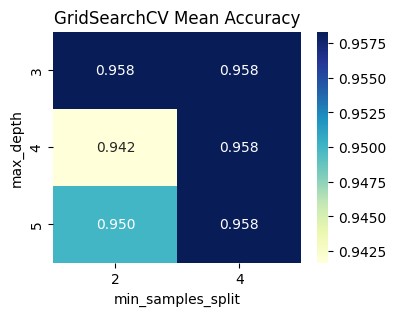

In [9]:
pivot_table = results.pivot_table(
    values="mean_test_score", index="param_max_depth", columns="param_min_samples_split"
)

plt.figure(figsize=(4, 3))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("GridSearchCV Mean Accuracy")
plt.ylabel("max_depth")
plt.xlabel("min_samples_split")

In [12]:
# -----------------------------
# 최종모델
# -----------------------------
best_model = gscv.best_estimator_

print(f"best_model: {best_model}")

best_model: DecisionTreeClassifier(max_depth=3, random_state=42)


In [11]:
# -----------------------------
# 최종 테스트
# -----------------------------
pred = best_model.predict(X_test)
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

